# Graph Analysis using Pig/Hadoop

Basic analysis over a relatively large social network graph derived from the billion triple challenge associated with the Semantic Web. The dataset is represented using the Resource Description Framework (RDF), where each record represents one edge in the graph.

RDF data is represented as a set of triples of the form:

   ```subject  predicate  object  [context]```

The [context] is not part of the triple, but is sometimes added to tell where the data is coming from. For example, file btc-2010-chunk-200 contains the two "triples" (they are actually "quads" because they have the context too):

```
<http://www.last.fm/user/ForgottenSound> <http://xmlns.com/foaf/0.1/nick> "ForgottenSound" <http://rdf.opiumfield.com/lastfm/friends/life-exe> .
<http://dblp.l3s.de/d2r/resource/publications/journals/cg/WestermannH96> <http://xmlns.com/foaf/0.1/maker> <http://dblp.l3s.de/d2r/resource/authors/Birgit\_Westermann> <http://dblp.l3s.de/d2r/data/publications/journals/cg/WestermannH96> .
```

Script runs on Elastic Map Reduce AWS instance

## Load data

In [ ]:
-- Choose either one of the two:

-- 2 Gbytes chunk of data
raw = LOAD 's3n://uw-cse-344-oregon.aws.amazon.com/btc-2010-chunk-000' USING TextLoader as (line:chararray); 

-- Whole dataset (~0.6 Tb)
raw = LOAD 's3n://uw-cse-344-oregon.aws.amazon.com/btc-2010-chunk-*' USING TextLoader as (line:chararray); 

## Parsing of RDF data

In [ ]:
register s3n://uw-cse-344-oregon.aws.amazon.com/myudfs.jar -- load user defined java functions for parsing

-- parse each line into ntriples
ntriples = FOREACH raw generate FLATTEN(myudfs.RDFSplit3(line)) as (subject:chararray,predicate:chararray,object:chararray);

describe ntriples
-- returns: ntriples: {subject: bytearray,predicate: bytearray, object: bytearray}


#### Sample raw record: 
```
<http://openean.kaufkauf.net/id/businessentities/GLN_7654990000088> <http://www.w3.org/2000/01/rdf-schema#isDefinedBy> <http://openean.kaufkauf.net/id/businessentities/> <http://openean.kaufkauf.net/id/businessentities/GLN_6406510000068> .

= <subject> <predicate> <object> <context>
```
#### Parsed triple:
```
(<http://openean.kaufkauf.net/id/businessentities/GLN_7654990000088>, <http://www.w3.org/2000/01/rdf-schema#isDefinedBy>, <http://openean.kaufkauf.net/id/businessentities/>)

= (<subject>, <predicate>, <object>)
```

### Group tuples by subject
### Create histogram data showing the distribution of counts per subject

In [ ]:
--group the n-triples by subject column
grunt> subjects = group ntriples by (subject) PARALLEL 50; 
grunt> describe subjects
subjects: {group: chararray,ntriples: {(subject: chararray,predicate: chararray,object: chararray)}}


grunt> subject_count = FOREACH subjects GENERATE FLATTEN($0), COUNT($1) AS count_subj PARALLEL 50;
grunt> describe subject_count
subject_count: {group: chararray,count_subj: long}

grunt> subject_tuple = GROUP subject_count BY count_subj;
grunt> describe subject_tuple
subject_tuple: {group: long,subject_count: {(group: chararray,count_subj: long)}}

-- histogram
hist = FOREACH subject_tuple GENERATE FLATTEN($0), COUNT($1) PARALLEL 50;

hist_ordered = order hist by (group);

-- store the results 
store hist_ordered into '/user/hadoop/hist' using PigStorage();

##### Merge files created on the hadoop filesystem

### Find all chains of length 2 within a subgraph

We consider the subgraph consisting of triples whose subject matches '.*rdfabout\\.com.*'.

Find all chains of lengths 2 in this subgraph = return all sextuples

    (subject, predicate, object, subject2, predicate2, object2) 
where
    
    object = subject2

Equivalent to a join operation

In [ ]:
grunt> ntriples1 = FILTER ntriples by subject MATCHES '.*rdfabout\\.com.*' PARALLEL 50;

grunt> ntriples2 = FOREACH ntriples1 GENERATE $0 as subject2, $1 AS predicate2, $2 AS object2 PARALLEL 50;

grunt> subgraph = JOIN ntriples1 BY object, ntriples2 BY subject2 PARALLEL 50;
grunt> describe subgraph
subgraph: {ntriples1::subject: chararray,ntriples1::predicate: chararray,ntriples1::object: chararray,ntriples2::subject2: chararray,ntriples2::predicate2: chararray,ntriples2::object2: chararray}

grunt> subgraph_d = DISTINCT subgraph PARALLEL 50;
grunt> describe subgraph_d
subgraph_d: {ntriples1::subject: chararray,ntriples1::predicate: chararray,ntriples1::object: chararray,ntriples2::subject2: chararray,ntriples2::predicate2: chararray,ntriples2::object2: chararray}

-- count number of subgraphs
grunt> subgraph_all = group subgraph_d ALL PARALLEL 50;
grunt> describe subgraph_all
subgraph_all: {group: chararray,subgraph_d: {(ntriples1::subject: chararray,ntriples1::predicate: chararray,ntriples1::object: chararray,ntriples2::subject2: chararray,ntriples2::predicate2: chararray,ntriples2::object2: chararray)}}

grunt> subgraph_count = FOREACH subgraph_all GENERATE COUNT(subgraph_d) PARALLEL 50;
grunt> describe subgraph_count
subgraph_count: {long}

## Plot histograms

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
hist_chunk = pd.read_csv('hist_chunk.txt', delimiter = '\t', header = None)

In [3]:
hist = pd.read_csv('hist_full.txt', delimiter = '\t', header = None)

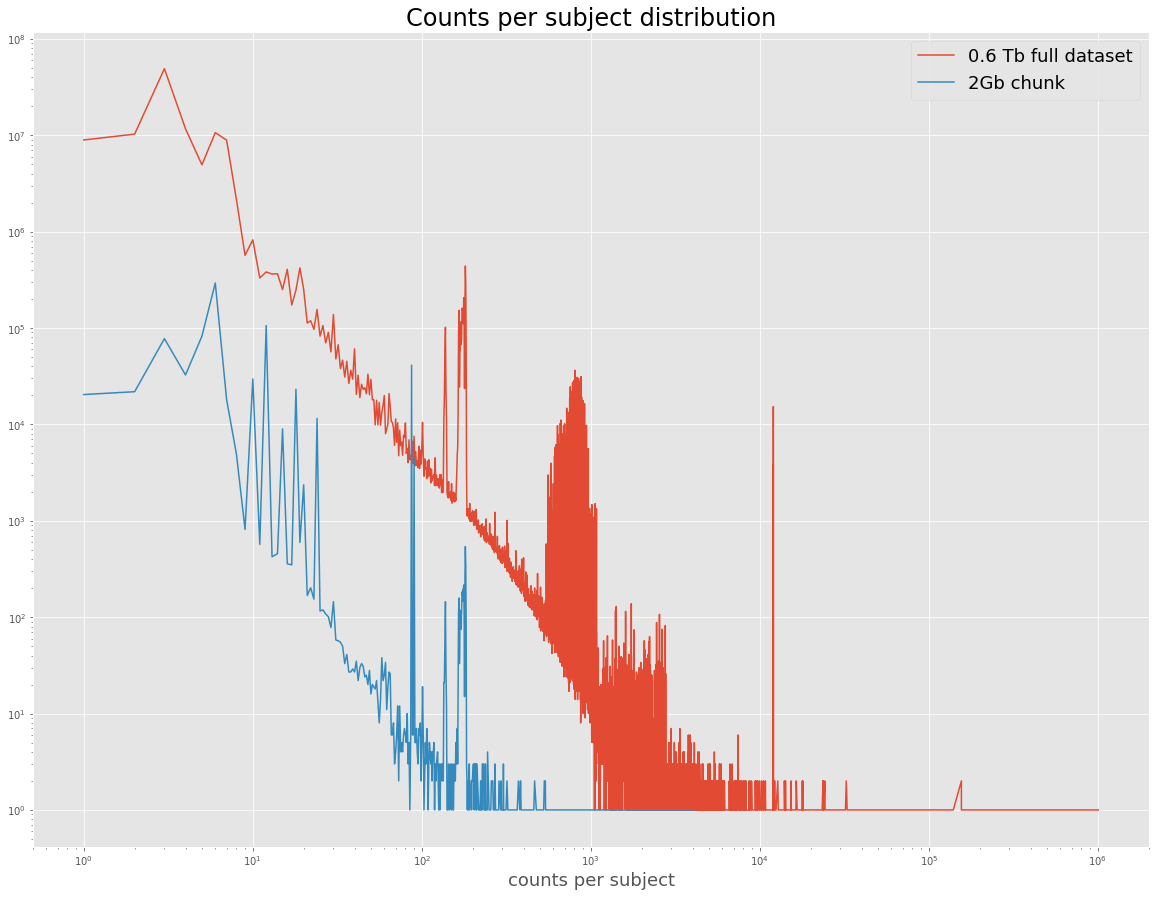

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title('Counts per subject distribution', fontsize=24)

x_chunk = hist_chunk[0].values
y_chunk = hist_chunk[1].values
x = hist[0].values
y = hist[1].values

ax.plot(x,y, label='0.6 Tb full dataset')
ax.plot(x_chunk, y_chunk, label='2Gb chunk')
ax.legend(loc = 'upper right', fontsize=18)
ax.set_xlabel('counts per subject', fontsize=18)

plt.show()
